### 🧭 Notebook 04 – Creative Exploration & Applications

---

#### **1. Introduction and Notebook Goals**

Welcome to the final notebook of **Project 10: Generative Adversarial Networks (GANs)**.  
In this notebook, we shift our focus from *training and evaluating GANs* to *creatively exploring* what a well-trained GAN can do.  

In the earlier notebooks, we’ve progressively built up our understanding:

- **Notebook 1 (Minimal GAN):** We learned the basic adversarial setup, where a *Generator* creates fake images and a *Discriminator* learns to tell them apart.  
- **Notebook 2 (DCGAN):** We extended this idea to *convolutional architectures*, allowing our generator to produce more realistic and structured artwork.  
- **Notebook 3 (Evaluation):** We explored the difficulty of assessing GAN quality — visually judging realism, diversity, and style balance.

Now, in **Notebook 4**, we step into the *creative dimension* of GANs.

**🎨 What We Will Do**

This notebook bridges the gap between *evaluation* and *creative expression*.  
Instead of optimizing losses or training new models, we will **use a pretrained DCGAN** to explore how its **latent space** (the space of random input vectors) captures artistic variation and creativity.

We will:

- **Use the pretrained DCGAN generator** to synthesize new artworks directly from noise vectors.  
- **Explore the latent space** to understand how small changes in the noise input ($z$) can produce smooth or dramatic changes in visual style.  
- **Blend and interpolate styles** by moving between two points in latent space, effectively creating hybrid or transitional artworks.  
- **Reflect on creative and ethical aspects** — how AI challenges our understanding of creativity, authorship, and originality.

**⚙️ Note on Practical Setup**

All experiments in this notebook use **pretrained model weights** (`dcgan_pretrained.pth`).  
We do *not* retrain any GAN here — this design keeps the runtime lightweight and **CPU-friendly**, while still allowing us to visualize realistic generated paintings.

The pretrained generator has already learned to represent several artistic styles (e.g., Impressionism, Cubism, Abstract Expressionism, Realism, Baroque, Symbolism) from a **balanced, downsampled WikiArt subset**.  

**🧠 Learning Goals**

By the end of this notebook, we should be able to:

- Understand how **latent space manipulations** lead to creative image variations.  
- Apply **latent interpolation and style blending** techniques to explore artistic transitions.  
- Discuss **creative, ethical, and philosophical implications** of AI-generated art.

**✨ A Thought to Begin With**

*“Every artist dips their brush in their own soul, and paints their own nature into their pictures.”* – Henry Ward Beecher  
Can a neural network do the same — and if so, whose soul does it paint?

Let’s explore.

---

#### **2. From Adversarial Training to Creativity**

In the earlier notebooks, we focused on how GANs *learn to generate* rather than *imitate explicitly*.  
Through adversarial learning, the **generator** and **discriminator** engaged in a continuous feedback loop:

- The **generator** tried to produce images that mimic real artworks from the dataset.  
- The **discriminator** attempted to distinguish real paintings from fake ones.  
- Over time, this adversarial game pushed the generator to *approximate the distribution of real artistic styles*.

Unlike supervised models that rely on labels or explicit reconstruction loss, GANs learn a **distribution of aesthetics** — color compositions, brush textures, spatial balance — through competitive training. This allows them to *internalize artistic diversity* rather than memorize individual paintings.

**Latent Space as a Canvas of Possibilities**

The generator’s input — a random noise vector \( z \) — isn’t just randomness; it’s a coordinate in a *latent space* that encodes the generator’s learned concept of “artistic possibility.”  
Each direction in this space can correspond to subtle stylistic variations:

- One axis might influence **color palette** or brightness.  
- Another might change **composition balance** or brushstroke style.  
- Yet another might shift **abstraction level** or **texture coherence**.

By exploring this latent space, we effectively navigate through the GAN’s learned imagination — discovering new blends and artistic transitions that weren’t explicitly present in the training set.

**Schematic Overview**
```text
Noise Vector (z) → Generator (G) → Artistic Image → Human Interpretation
```



Here, the generator transforms abstract numerical patterns into visual representations, which we interpret through our human lens of creativity and meaning.

**Reflection Prompt**

*Is creativity just structured randomness, or guided imitation?*  
When we see a GAN produce a visually compelling painting, are we witnessing creativity — or just statistical echoes of patterns it has seen before?  
This question lies at the heart of AI-driven art and the philosophical boundary between imitation and invention.

---

#### **3. Setup and Pretrained Model Loading**

Before we begin exploring creativity with our GAN, let’s first prepare our environment and load the **pretrained DCGAN generator** that we trained earlier.  
We will use it to synthesize new paintings directly from latent vectors $ z $ — no training required.

**Goal:**  
Prepare the pretrained DCGAN model for creative exploration.

**Step 1: Import Required Libraries**

We begin by importing the necessary PyTorch modules and utility libraries.

In [1]:
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Device setup (CPU-friendly, as in your NB04)
device = torch.device("cpu")
print("Device in use:", device)

Device in use: cpu


**Step 2: Define the Generator Architecture (for Consistency)**

To load pretrained weights, we must define the same architecture as before.
This ensures that the model structure matches the saved .pth file.

In [2]:
# === EXACT SAME GENERATOR AS IN PRETRAINING (self.net, *4 plan) ===
class GeneratorDCGAN(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, feature_maps=64):
        super().__init__()
        self.net = nn.Sequential(
            # (N, z_dim, 1, 1) -> (N, feature_maps*4, 4, 4)
            nn.ConvTranspose2d(z_dim, feature_maps*4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_maps*4),
            nn.ReLU(True),

            # 4x4 -> 8x8
            nn.ConvTranspose2d(feature_maps*4, feature_maps*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps*2),
            nn.ReLU(True),

            # 8x8 -> 16x16
            nn.ConvTranspose2d(feature_maps*2, feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            # 16x16 -> 32x32
            nn.ConvTranspose2d(feature_maps, feature_maps//2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps//2),
            nn.ReLU(True),

            # 32x32 -> 64x64
            nn.ConvTranspose2d(feature_maps//2, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        if z.dim() == 2:
            z = z.view(z.size(0), z.size(1), 1, 1)
        return self.net(z)

**Step 3: Load the Pretrained Weights**

We now instantiate the generator and load the pretrained parameters.
This model was trained on a subset of the WikiArt dataset for 10 epochs.

In [5]:
# === Load pretrained generator (matches your training script exactly) ===
G_pretrained = GeneratorDCGAN(z_dim=100, img_channels=3, feature_maps=64).to(device)
state = torch.load("dcgan_pretrained.pth", map_location=device)
G_pretrained.load_state_dict(state, strict=True)
G_pretrained.eval()
print("✅ Pretrained DCGAN Generator loaded successfully (feature_maps=64, self.net).")

C:\Users\noman\AppData\Local\Temp\ipykernel_40020\3363772976.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("dcgan_pretrained.pth", map_location=devi

✅ Pretrained DCGAN Generator loaded successfully (feature_maps=64, self.net).


**Step 4: Generate Sample Paintings**

Let’s create a batch of random latent vectors z and visualize the generated outputs.
We fix the random seed for reproducibility.

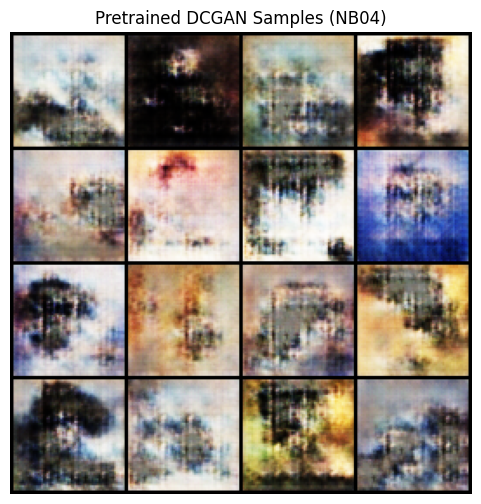

In [6]:
# Set manual seed for reproducibility
torch.manual_seed(42)

# === Quick sample (optional) ===
with torch.no_grad():
    z = torch.randn(16, 100, 1, 1, device=device)
    fake = G_pretrained(z).cpu()

grid = make_grid((fake + 1) / 2, nrow=4)
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis("off")
plt.title("Pretrained DCGAN Samples (NB04)")
plt.show()

At this stage, we can already see artistic structures emerging — brush-like textures, balanced compositions, and color harmony that mimic real artistic styles.

---

#### **4. Exploring Diversity in Latent Space**

In a GAN, the latent vector $z \sim \mathcal{N}(0, I)$ acts like a **creative code**.  
If our generator has learned a meaningful representation, then **small, smooth changes** in $z$ should produce **small, smooth changes** in the output image (color palette, textures, composition). Here, we will:

1. **Fix most dimensions of $z$** and vary only a **couple of coordinates**, to see targeted changes.  
2. Create a **2D traversal grid** around a base latent vector to visualize local diversity.  
3. Reflect on whether changes are **smooth** (good sign) or **chaotic/jumpy** (poorly structured latent space).

We will use our **pretrained DCGAN** so that the latent space is already well-formed.

In [7]:
# Setup: we expect a pretrained generator named G_pretrained (from Section 2)
import torch, torchvision, numpy as np, matplotlib.pyplot as plt

assert 'G_pretrained' in globals(), "Please run Section 2 to load `G_pretrained`."
G_eval = G_pretrained.eval()
device = next(G_eval.parameters()).device

latent_dim = 100

def denorm(x):
    return (x + 1) / 2

@torch.no_grad()
def decode_latents(Z):
    """
    Z: (N, latent_dim, 1, 1)
    Returns: images tensor in [-1, 1]
    """
    return G_eval(Z).cpu()

def show_grid(imgs, nrow, title):
    grid = torchvision.utils.make_grid(denorm(imgs).clamp(0,1), nrow=nrow, padding=2)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.title(title)
    plt.show()

**A. 1D Traversal (fix all but one coordinate)**

We pick a base $z_0$ and vary **one dimension** $z_k$ across a range (e.g., $[-2, -1, \dots, 2]$).  
If the latent space is well-structured, we should see **gradual changes** along a coherent semantic axis (e.g., lighting, color warmth, brush texture).


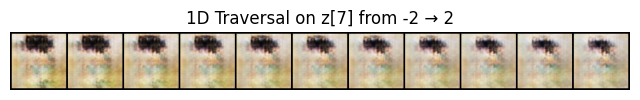

In [8]:
# 1D traversal: vary a single coordinate k and keep others fixed
torch.manual_seed(7)
z0 = torch.randn(1, latent_dim, 1, 1, device=device)

k = 7                         # which dimension to vary
values = torch.linspace(-2.0, 2.0, steps=11).to(device)

Z = []
for v in values:
    z = z0.clone()
    z[:, k, :, :] = v
    Z.append(z)
Z = torch.cat(Z, dim=0)       # (11, latent_dim, 1, 1)

imgs_1d = decode_latents(Z)
show_grid(imgs_1d, nrow=11, title=f"1D Traversal on z[{k}] from -2 → 2")

**B. 2D Traversal Grid (fix all but two coordinates)**

Next, we vary **two coordinates** $(z_i, z_j)$ over a grid.  
This gives us a **map** of how local neighborhoods in latent space correspond to stylistic variations.

We will choose $(i, j)$ and sweep a grid over $[-2, 2]\times[-2, 2]$ while keeping the other 98 coordinates fixed.


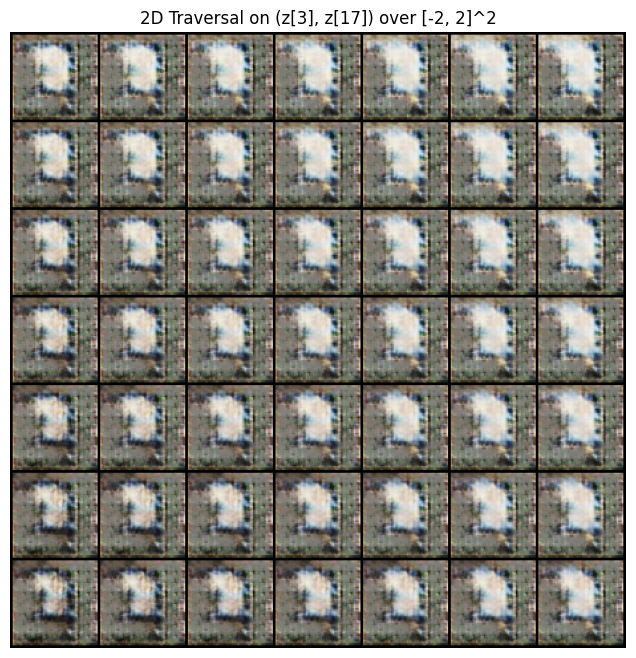

In [9]:
# 2D traversal: vary two coordinates (i, j) across a grid
torch.manual_seed(13)
z0 = torch.randn(1, latent_dim, 1, 1, device=device)

i, j = 3, 17                     # two latent dimensions to sweep
grid_lin = torch.linspace(-2.0, 2.0, steps=7).to(device)  # 7x7 grid

Z_list = []
for a in grid_lin:               # vertical axis (row)
    for b in grid_lin:           # horizontal axis (col)
        z = z0.clone()
        z[:, i, :, :] = a
        z[:, j, :, :] = b
        Z_list.append(z)

Z_grid = torch.cat(Z_list, dim=0)  # (49, latent_dim, 1, 1)
imgs_2d = decode_latents(Z_grid)
show_grid(imgs_2d, nrow=len(grid_lin), title=f"2D Traversal on (z[{i}], z[{j}]) over [-2, 2]^2")


**C. Partial-Fix Traversal (vary several dims, keep a semantic “core”)**

Sometimes it helps to **stabilize a small subset** of coordinates (e.g., those that seem to control composition) and let a few others vary to see **texture or palette** changes. We can randomly choose a handful of indices to vary while keeping the rest fixed.


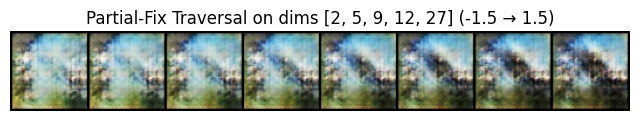

In [10]:
# Partial-fix traversal: vary a small set of dims jointly, others fixed
torch.manual_seed(21)
z0 = torch.randn(1, latent_dim, 1, 1, device=device)

vary_idx = torch.tensor([2, 5, 9, 12, 27], device=device)  # a few coords to vary
steps = 8
alphas = torch.linspace(-1.5, 1.5, steps=steps).to(device)

Z_list = []
for a in alphas:
    z = z0.clone()
    z[:, vary_idx, :, :] = a
    Z_list.append(z)
Z_line = torch.cat(Z_list, dim=0)  # (steps, latent_dim, 1, 1)

imgs_partial = decode_latents(Z_line)
show_grid(imgs_partial, nrow=steps, title=f"Partial-Fix Traversal on dims {vary_idx.tolist()} (-1.5 → 1.5)")


**How we interpret what we see**

- If **small changes** in $z$ produce **small visual changes**, the latent space likely encodes **smooth, meaningful factors** (good).  
- If outputs **jump abruptly** with tiny latent changes, the mapping is **fragile** (poorly structured or undertrained).  
- Specific coordinates can act like **semantic sliders** (e.g., warmth of colors, smoothness of strokes, density of patterns).  
- The **2D grids** help us see **interactions** between two factors (e.g., color tone vs. texture sharpness).

---

#### **5. Latent Interpolation (Between Two Paintings)**

A compelling way to explore a GAN’s **creative latent space** is through **interpolation** between two latent codes.  
If the latent manifold is **smooth and coherent**, linearly blending between two random points in $ z $-space should produce a **gradual morph** between two distinct artistic “styles” — showing evolving **color palettes**, **textures**, and **composition**.

**What we’ll do**

- Sample two random latent vectors $ z_1 $ and $ z_2 $.  
- Interpolate between them using 10 evenly spaced coefficients:
  $$
  z_\alpha = (1-\alpha)\,z_1 + \alpha\,z_2,\quad \alpha \in \left\{0,\tfrac{1}{9},\tfrac{2}{9},\dots,1\right\}.
  $$
- Decode each $ z_\alpha $ using our pretrained generator $ G $.
- Visualize the 10 generated images in a **horizontal gallery**.

**How to interpret the gallery**

- ✅ **Smooth progression left → right:** indicates a continuous, structured latent space.  
- ⚠️ **Abrupt jumps or disjoint transitions:** reveal discontinuities or limited diversity (possible mode collapse).

As we examine the interpolation, we should note:
- Are changes smooth in both **color tone** and **composition**?  
- Do intermediate images look plausible, or do they “break apart” mid-way?  
- Does the generator show **semantic blending** (conceptual morphs) or only **textural blending** (color/texture transitions)?

This test helps us assess how well the model *organizes its imagination*.


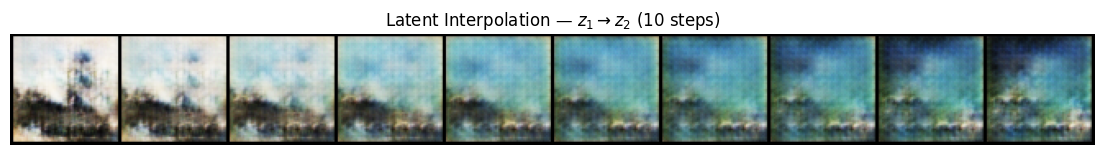

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# --- Ensure pretrained generator G is loaded ---
assert 'G_pretrained' in globals(), "Please run Section 3 to load pretrained generator as 'G_pretrained'."
G_pretrained.eval()
device = next(G_pretrained.parameters()).device

# --- Linear interpolation function ---
@torch.no_grad()
def interpolate_linearly(z1, z2, steps=10):
    """
    Linear interpolation between z1 and z2 in latent space.
    z1, z2: tensors of shape (1, z_dim, 1, 1)
    returns: tensor of shape (steps, z_dim, 1, 1)
    """
    alphas = torch.linspace(0.0, 1.0, steps, device=z1.device)
    Z = [(1 - a) * z1 + a * z2 for a in alphas]
    return torch.cat(Z, dim=0)

# --- Sample latent endpoints ---
torch.manual_seed(42)
z_dim = 100
z1 = torch.randn(1, z_dim, 1, 1, device=device)
z2 = torch.randn(1, z_dim, 1, 1, device=device)

# --- Generate interpolation sequence ---
Z_line = interpolate_linearly(z1, z2, steps=10)
with torch.no_grad():
    imgs = G(Z_line).cpu()
imgs = (imgs + 1) / 2  # denormalize to [0,1]

# --- Plot horizontal gallery ---
grid = make_grid(imgs, nrow=10, padding=2)
plt.figure(figsize=(14, 2.2))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis("off")
plt.title("Latent Interpolation — $z_1 \\rightarrow z_2$ (10 steps)")
plt.show()


**Reflection**

- **Visual continuity.**  
  The transition from lighter beige tones to cooler blue-green hues appears *smooth and gradual*, suggesting that the generator’s latent space is **continuous and well-structured**. Each step modifies color temperature and composition without abrupt artifacts.

- **Interpretation.**  
  This implies the generator has learned *semantic coherence*: neighboring latent codes correspond to paintings that differ in tone and atmosphere but remain stylistically plausible.  
  The changes mainly affect **palette warmth** and **textural density**, rather than introducing new forms — a sign that the model captures surface-level attributes more strongly than compositional variation.

- **Potential improvements.**  
  If we wish to see stronger compositional changes, we could:
  - Train longer or on a more diverse subset of paintings.  
  - Sample endpoints $ z_1, z_2 $ farther apart in latent space.  
  - Interpolate with more steps (20–30) to reveal subtler transitions.

Overall, these results demonstrate a **locally smooth but partially collapsed latent manifold** — visually consistent yet limited in diversity, typical for mid-trained DCGANs.

---

#### **6. Style Blending and Latent Semantics**

In this optional experiment, we explore **style blending** — mixing two different latent codes to create a *hybrid* painting that visually combines artistic traits from both.

We treat the **latent vector $ z $** as an internal “DNA” of the generated artwork:
- Some dimensions may influence **color palette** (e.g., warm vs. cool tones).  
- Others may affect **composition** or **texture** (e.g., abstract vs. structured strokes).  

By merging parts of two latent codes, we can observe how GANs internally organize **visual semantics** — whether attributes like color and texture are **disentangled** (independent) or **entangled** (interacting).

**Plan**

1. Sample two latent vectors, $ z_A $ and $ z_B $.  
2. Construct a *hybrid* vector:
   $$
   z_{\text{mix}} = [\,z_A^{(0:50)},\, z_B^{(50:100)}\,]
   $$
   i.e., first 50 dimensions from $ z_A $ and last 50 from $ z_B $.  
3. Decode $ z_A $, $ z_B $, and $ z_{\text{mix}} $ using the pretrained generator.

**Interpretation**

- If the hybrid painting exhibits **blended features** (e.g., *colors from A, structure from B*), it suggests that the generator’s latent space contains **disentangled, interpretable factors**.  
- If the mix appears random or unstable, it indicates **entanglement** — visual attributes interact in nonlinear ways, typical of early GANs.


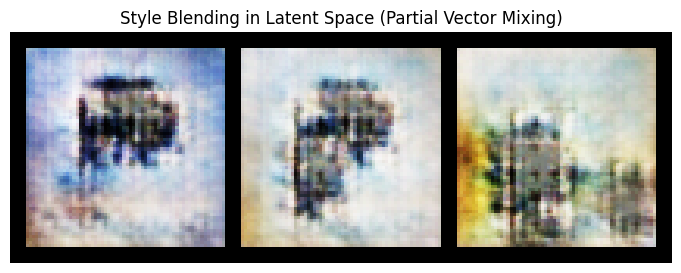

In [14]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

# --- Ensure pretrained generator G is loaded ---
assert 'G' in globals(), "Please run Section 3 to load pretrained generator as 'G'."
G.eval()
device = next(G.parameters()).device
z_dim = 100

@torch.no_grad()
def blend_latent_styles(zA, zB, split_index=50):
    """
    Create a hybrid latent vector by combining the first part of zA and the rest of zB.
    """
    return torch.cat([zA[:, :split_index, :, :], zB[:, split_index:, :, :]], dim=1)

# --- Random seeds for reproducibility ---
torch.manual_seed(100)
zA = torch.randn(1, z_dim, 1, 1, device=device)
zB = torch.randn(1, z_dim, 1, 1, device=device)
z_mix = blend_latent_styles(zA, zB, split_index=50)

# --- Generate the three paintings ---
with torch.no_grad():
    imgs = G(torch.cat([zA, z_mix, zB], dim=0)).cpu()

# --- Normalize and display ---
imgs = (imgs + 1) / 2
titles = ["Style A", "Mixed (A+B)", "Style B"]

grid = make_grid(imgs, nrow=3, padding=5)
plt.figure(figsize=(9, 3))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis("off")
plt.title("Style Blending in Latent Space (Partial Vector Mixing)")
plt.show()


**Discussion & Reflection**

- *Do we see hybridization?*  
  Look for intermediate characteristics: perhaps the **color tones** of Style A merged with the **composition** of Style B.

- *Latent semantics.*  
  Certain latent dimensions may capture **semantic properties** like hue, shape, or texture.  
  When these are blended selectively, we effectively *compose new art styles* that never existed in the training data.

- *Big picture question:*  
  **What does this tell us about the GAN’s internal representation of style?**  
  It suggests that the generator has learned an internal *basis of artistic variation*, where each latent component contributes to distinct visual or stylistic traits — much like how human artists vary brushwork, composition, or mood.

💡 *Try experimenting:* change the split index or combine more than two sources to create multi-style hybrids!

---

#### **7. Creative Applications of GANs**

Generative Adversarial Networks (GANs) have moved far beyond research demos — they now play a major role in **creative industries**, education, and digital innovation. Let’s explore how their generative power enables new forms of **artistic and functional creativity**.

**🎨 Art and Design**

- **AI-assisted painting:** Artists use GANs to generate initial sketches or color palettes, then refine them manually — creating a collaboration between human intent and machine exploration.  
- **Interactive art tools:** GANs power real-time applications where users can manipulate *latent sliders* to explore evolving designs, much like tuning creativity knobs.  
- **Exhibitions and installations:** Museums increasingly use GAN-generated works to question authorship and creativity in the digital age.

**📈 Data Augmentation**

- In domains where data is scarce (e.g., medical imaging or niche art forms), GANs can **synthesize new samples** that resemble real ones.  
- For example, generating more paintings of underrepresented art movements ensures **balanced datasets**, reducing bias during model training.

**🎬 Media and Entertainment**

- **Concept art generation:** GANs rapidly produce background designs, textures, and lighting variations, speeding up creative workflows in film and gaming.  
- **Style transfer:** Combining classical and modern aesthetics to reimagine familiar visuals — think “Van Gogh meets Cyberpunk.”  
- **Texture generation:** Artists use GANs to create intricate, tileable surfaces for 3D environments.

**🎓 Education and Research**

- Students can explore how GANs reinterpret **art movements** by generating paintings in the style of Impressionism, Cubism, or Surrealism.  
- GANs also serve as **visual teaching tools** for understanding complex statistical concepts such as distributions, latent spaces, and optimization.

**💭 Reflection**

*How does GAN-based creativity complement human artistic intent?*  

GANs do not replace artists — instead, they act as **collaborative instruments** that extend human imagination.  
While the human mind provides **concept, meaning, and emotion**, GANs contribute **novel variations and unexpected associations**, revealing new creative directions.  

Ultimately, **the most compelling art arises from synergy** — where human intuition and machine abstraction inspire each other to produce something neither could create alone.

---

#### **8. Ethical and Societal Considerations**

As we step into the creative frontier of AI-generated art, it’s vital to pause and reflect on the **ethical and societal implications** that accompany such technologies.  
GANs, while inspiring and innovative, also raise questions about **authorship, authenticity, and responsibility** in the digital age.

**⚠️ Deepfakes and Misinformation**

- The same generative technology that creates art can also be used to produce **deepfakes** — hyper-realistic fake media that spread misinformation or manipulate public perception.  
- Artists and technologists alike must understand the dual nature of this power: creativity and deception exist on the same technical spectrum.  
- Ethical use of GANs involves **transparency**, **consent**, and **context** — clearly communicating when content has been generated or altered by AI.

**🧾 Copyright and Authorship**

- Who owns AI-generated art — the human who trained the model, the organization that built it, or the machine itself?  
- Because GANs often learn from existing artworks, questions arise around **derivative works** and **fair use**.  
- Current copyright laws struggle to address **machine creativity**, leading to debates about whether AI outputs should be considered *authored* at all.  
- Many creators advocate for labeling AI art clearly, ensuring viewers can distinguish **original human work** from **algorithmic reinterpretation**.


**🌍 Dataset Bias and Cultural Representation**

- The datasets used to train GANs often overrepresent certain **art movements**, **regions**, or **cultural aesthetics**, unintentionally amplifying bias.  
- If a dataset primarily includes Western art, the GAN’s “creative imagination” may underrepresent non-Western forms.  
- Responsible AI art development requires **diverse, inclusive datasets** and thoughtful curation to ensure balanced representation.

**💬 Reflection Discussion**

*Should AI-generated art be labeled as such?*  
*What constitutes originality in the age of GANs?*  

Encourage yourself to think critically:
- Transparency promotes trust — labeling AI art preserves integrity in digital spaces.  
- Originality may no longer depend solely on authorship but on **conceptual intent** — how humans use AI as an expressive medium rather than a replacement for creativity.  

GANs challenge us to **redefine creativity** — not as an exclusive human trait, but as a shared dialogue between human purpose and machine possibility.

---

#### **9. Summary and Reflection**

We have now completed our journey through the **GANs module**, progressing from foundational understanding to creative exploration.  
This final section consolidates what we’ve learned and prepares us to transition toward **transfer learning and model fine-tuning** in Project 11.

**🧩 Summary of Key Learning Outcomes**

- **Notebook 1 – Minimal GAN:**  
  We introduced the core *adversarial training* setup, where the **Generator** learns to produce realistic outputs while the **Discriminator** learns to distinguish fake from real. This built our intuition about the *push-and-pull dynamics* that define GANs.

- **Notebook 2 – DCGAN:**  
  We extended this idea using **convolutional layers** to stabilize training and improve image quality.  
  The **DCGAN architecture** showed us how spatial hierarchies and feature maps preserve texture and structure — leading to more coherent art generation.

- **Notebook 3 – Evaluating GANs:**  
  We explored the **challenges of GAN evaluation** — discovering that unlike accuracy or loss metrics, evaluation in generative modeling relies on *visual quality, diversity, and stability*.  
  We also examined *mode collapse* and *latent diversity* to understand where GANs succeed and where they struggle.

- **Notebook 4 – Creative Exploration:**  
  We leveraged our pretrained GAN for **artistic creativity** — performing latent traversals, style blending, and interpolation.  
  Finally, we discussed **ethical implications** such as deepfakes, authorship, and dataset bias, connecting technical progress to responsible innovation.

**🚀 Forward Link: Toward Project 11 – Transfer Learning & Fine-Tuning**

In the next project, we will shift our focus from generative art to **adaptation and reuse of pretrained models**.  
Project 11 introduces **Transfer Learning**, where we’ll explore:
- How pretrained networks can be fine-tuned for new tasks.  
- Feature extraction and reuse of learned representations.  
- Balancing generalization and overfitting in downstream domains.

This transition represents an important step from *creating data* (GANs) to *adapting knowledge* (transfer learning).

**💭 Reflection Question**

*Can machines be creative on their own, or are they mirrors of human creativity?*  

Consider this:
- GANs learn from human art — yet generate pieces that no artist has ever painted.  
- Are they simply **statistical mirrors**, or do they exhibit a form of **emergent imagination** born from mathematical structure?  

The answer may lie not in choosing one side, but in recognizing that **creativity itself is a continuum** — one that now spans both human and machine intelligence.
